In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [14]:
filepath = '/content/texas_2009_to_2019_dataset01.csv'
df = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')
# print(df.shape)  # (123, 8)
df.tail()

,MWh,uvIndex,HeatIndexC,WindChillC,humidity,tempC
Date,,,,,,
2019-12-31 19:00:00,829.983729,4,14,12,61,14
2019-12-31 20:00:00,825.761799,4,11,9,65,11
2019-12-31 21:00:00,822.190573,4,9,7,69,9
2019-12-31 22:00:00,819.394012,4,7,4,73,7
2019-12-31 23:00:00,804.714775,4,6,2,73,6


In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

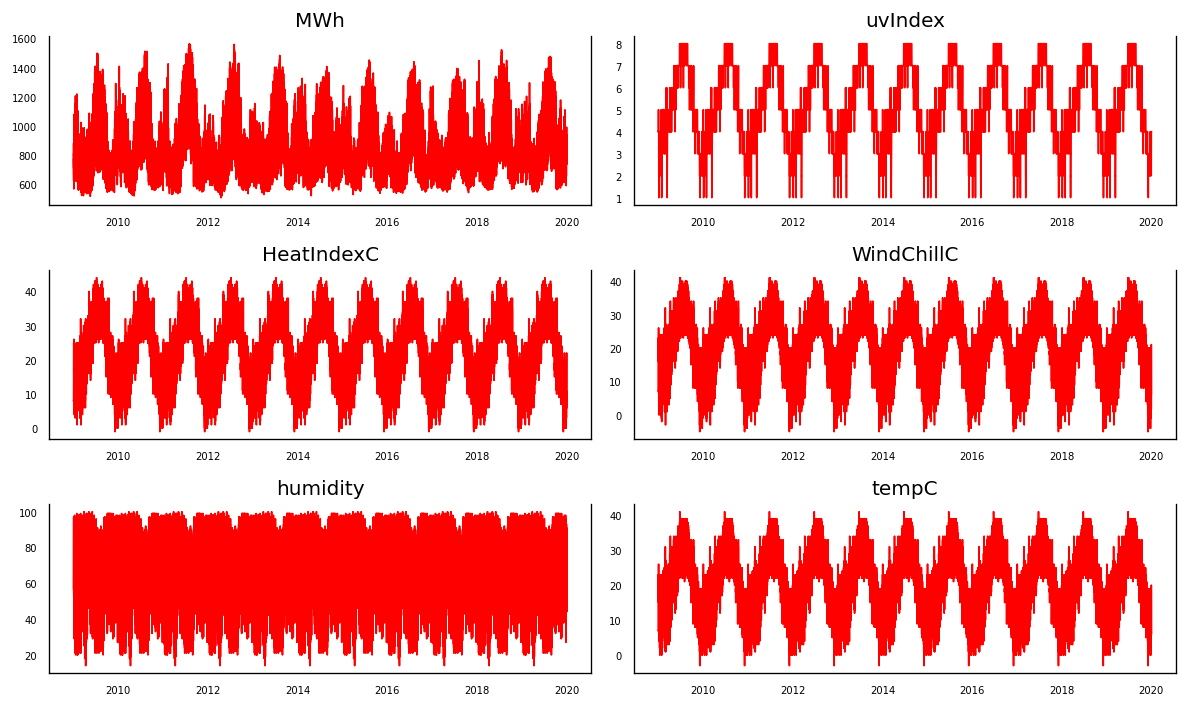

In [15]:
# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):

  if i<6:
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [21]:
nobs = 24
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape) 

df_test.head()


(96383, 6)
(24, 6)


,MWh,uvIndex,HeatIndexC,WindChillC,humidity,tempC
Date,,,,,,
2019-12-31 00:00:00,823.984073,2,9,7,86,8
2019-12-31 01:00:00,825.967225,4,9,7,84,8
2019-12-31 02:00:00,828.980046,4,9,7,85,8
2019-12-31 03:00:00,836.252905,4,8,7,85,8
2019-12-31 04:00:00,848.356301,4,8,6,86,8


In [22]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=168
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_differenced, variables = df_differenced.columns)      

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_differenced)

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    



# # ADF Test on each column
# for name, column in df_train.iteritems():
#     adfuller_test(column, name=column.name)
#     print('\n')


# ADF Test on each column
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

In [ ]:
#find minimum AIC value
model = VAR(df_differenced)
result = model.fit(50)
min = result.aic
for i in range(51,150):
  result = model.fit(i)
  a = result.aic
  print(a)




In [ ]:
# model = VAR(df_differenced)
# for i in [1,2,3,4,5,6,7,8,9]:
#     result = model.fit(i)
#     print('Lag Order =', i)
#     print('AIC : ', result.aic)
#     print('BIC : ', result.bic)
#     print('FPE : ', result.fpe)
#     print('HQIC: ', result.hqic, '\n')

In [ ]:
# x = model.select_order(maxlags=168)
# x.summary()

In [ ]:
model_fitted = model.fit(168)
model_fitted.summary()

In [ ]:
from statsmodels.stats.stattools import durbin_watson

def adjust(val, length= 6): return str(val).ljust(length)


out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

In [ ]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
print(forecast_input.shape)
forecast_input

In [ ]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc


# print(df_train)
# print(df_forecast)

df_results = invert_transformation(df_train, df_forecast, second_diff=True)
df_results.loc[:, ['MWh_forecast', 'uvIndex_forecast', 'HeatIndexC_forecast', 'WindChillC_forecast', 'humidity_forecast', 'tempC_forecast']]

In [ ]:
df_test

In [ ]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    #have an accuracy counter
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
    

print("mean absolute percentage error, mean error, mean absolute error, mean percentage error, root mean squared error, correlation,minmax")

#'MWh_forecast', 'uvIndex_forecast', 'HeatIndexC_forecast', 'WindChillC_forecast', 'humidity_forecast', 'tempC_forecast'
print('Forecast Accuracy of: MWh')
accuracy_prod = forecast_accuracy(df_results['MWh_forecast'].values, df_test['MWh'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: uvIndex')
accuracy_prod = forecast_accuracy(df_results['uvIndex_forecast'].values, df_test['uvIndex'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: HeatIndexC')
accuracy_prod = forecast_accuracy(df_results['HeatIndexC_forecast'].values, df_test['HeatIndexC'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: WindChillC')
accuracy_prod = forecast_accuracy(df_results['WindChillC_forecast'].values, df_test['WindChillC'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: humidity')
accuracy_prod = forecast_accuracy(df_results['humidity_forecast'].values, df_test['humidity'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: tempC')
accuracy_prod = forecast_accuracy(df_results['tempC_forecast'].values, df_test['tempC'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
